# Inputation

In [1]:
"""FIML estimation of the mean/covariance of data with missing values.
This is an implementation of full information maximum likelihood (FIML)
method to estimate the mean and the covariance of data with missing
values.
"""

import numpy as np
import scipy as sp
import scipy.optimize

_log2pi = np.log(2 * np.pi)

def fiml(data, bias=False):
    """FIML estimation of the mean/covariance of data with missing values.
    Estimate the mean and the covariance of data with missing values by
    full information maximum likelihood (FIML) method.
    Parameters
    ----------
    data : ndarray
        A 2-D array containing variables and observations.
        Each row is an observation and each column is a variable.
        A missing value is represented by `np.nan`.
    bias : bool, optional
        Must be True for now.
    Returns
    -------
    mean : ndarray
        Estimated means of the variables.
    cov : ndarray
        Estimated covariance of the variables.
    """

    if not bias:
        raise NotImplementedError("unbiased estimator is not yet implemented")

    size, dim = data.shape
    mean0 = np.zeros(dim)
    cov0 = np.eye(dim)
    params0 = _pack_params(dim, mean0, cov0)
    data_blocks = _sort_missing(data)
    result = sp.optimize.fmin_slsqp(
        _obj_func, params0, args=(dim, data_blocks), disp=False)
    mean, cov = _unpack_params(dim, result)
    return mean, cov

# Sort data by the missing patterns.
# The return value is in the following format.
# Missing variables (columns) are removed from the data blocks.
#  [(observation_pattern1, data_block1),
#   (observation_pattern2, data_block2),
#   ...]
def _sort_missing(data):
    # Argsort the rows of obsmap.
    obsmap = ~np.isnan(data)
    sortedidx = sorted(range(data.shape[0]), key=lambda i: list(obsmap[i]))
    # Split row indexes into blocks.
    blocks = [[sortedidx[0]]]
    for idx, prev in zip(sortedidx[1:], sortedidx[:-1]):
        if (obsmap[prev] == obsmap[idx]).all():
            blocks[-1].append(idx)
        else:
            blocks.append([idx])
    return [(obsmap[b[0]], data[b][:, obsmap[b[0]]]) for b in blocks]

# Pack the mean and the covariance into a 1-dimensional array.
# - The first N values are the means.
# - The remaining N (N + 1) / 2 values are the lower triangular matrix
#   of the covariance.
def _pack_params(dim, mean, cov):
    params = np.empty(dim + dim * (dim + 1) // 2)
    params[:dim] = mean
    params[dim:] = cov[np.tril_indices(dim)]
    return params

# Unpack the mean and the covariance from a 1-dimensional array.
def _unpack_params(dim, params):
    mean = params[0:dim]
    cov = np.empty((dim, dim))
    ii, jj = np.tril_indices(dim)
    cov[ii, jj] = params[dim:]
    cov[jj, ii] = params[dim:]
    return mean, cov

def _obj_func(params, dim, data_blocks):
    mean, cov = _unpack_params(dim, params)
    # Check if cov is positive semidefinite.
    # A matrix has a Cholesky decomposition iff it is symmetric and
    # positive semidefinite.  It is said that Cholesky decomposition is
    # faster and more numerically stable than finding eigenvalues.
    # However, numpy.linalg.cholesky() rejects singular matrices (i.e.,
    # strictly "semi"-definite ones).
    # try:
    #     _ = np.linalg.cholesky(cov)
    # except np.linalg.LinAlgError:
    #     return np.inf
    if (np.linalg.eigvalsh(cov) < 0).any():
        # XXX Returning inf is not a good idea, because many solvers
        # cannot cope with it.
        return np.inf
    objval = 0.0
    for obs, obs_data in data_blocks:
        obs_mean = mean[obs]
        obs_cov = cov[obs][:, obs]
        objval += _log_likelihood_composed(obs_data, obs_mean, obs_cov)
    return -objval

def _obj_func_1d(params, dim, data):
    mean, cov = _unpack_params(dim, params)
    objval = 0.0
    for x in data:
        obs = ~np.isnan(x)
        objval += _log_likelihood_1d(x[obs], mean[obs], cov[obs][:, obs])
    return -objval

# Composite function of _log_likelihood() and _pdf_normal().
def _log_likelihood_composed(x, mean, cov):
    xshift = x - mean
    t1 = x.shape[-1] * _log2pi
    sign, logdet = np.linalg.slogdet(cov)
    t2 = logdet
    t3 = xshift.dot(np.linalg.inv(cov)) * xshift
    size = x.shape[0] if x.ndim == 2 else 1
    return -0.5 * ((t1 + t2) * size + t3.sum())

# Log likelihood function.
# The input x can be one- or two-dimensional.
def _log_likelihood(x, mean, cov):
    return np.log(_pdf_normal(x, mean, cov)).sum()

# Log likelihood function.
def _log_likelihood_1d(x, mean, cov):
    return np.log(_pdf_normal_1d(x, mean, cov))

# Probability density function of multivariate normal distribution.
# The input x can be one- or two-dimensional.
def _pdf_normal(x, mean, cov):
    xshift = x - mean
    t1 = (2 * np.pi) ** (-0.5 * x.shape[-1])
    t2 = np.linalg.det(cov) ** (-0.5)
    t3 = -0.5 * (xshift.dot(np.linalg.inv(cov)) * xshift).sum(axis=-1)
    return t1 * t2 * np.exp(t3)

# Probability density function of multivariate normal distribution.
def _pdf_normal_1d(x, mean, cov):
    xshift = x - mean
    t1 = (2 * np.pi) ** (-0.5 * len(x))
    t2 = np.linalg.det(cov) ** (-0.5)
    t3 = -0.5 * xshift.dot(np.linalg.inv(cov)).dot(xshift)
    return t1 * t2 * np.exp(t3)

Covariance


,AC_consumption_W,hour,day_wk
AC_consumption_W,11679.632077,185.794197,-27.008125
hour,185.794197,48.374279,0.089533
day_wk,-27.008125,0.089533,4.205017


Correlation


,AC_consumption_W,hour,day_wk
AC_consumption_W,1.000000,0.248512,-0.121170
hour,0.248512,1.000000,0.006278
day_wk,-0.121170,0.006278,1.000000


P_Values


,AC_consumption_W,hour,day_wk
AC_consumption_W,0,0.0001,0.0614
hour,0.0001,0,0.6953
day_wk,0.0614,0.6953,0


[ 11.39227987 167.83492643] [[ 9538.88936103 -2965.16443854]
 [-2965.16443854  6249.15423434]]
[  3.58224333 167.83786426] [[57164.60691179  -173.06410778]
 [ -173.06410778  5259.11766116]]


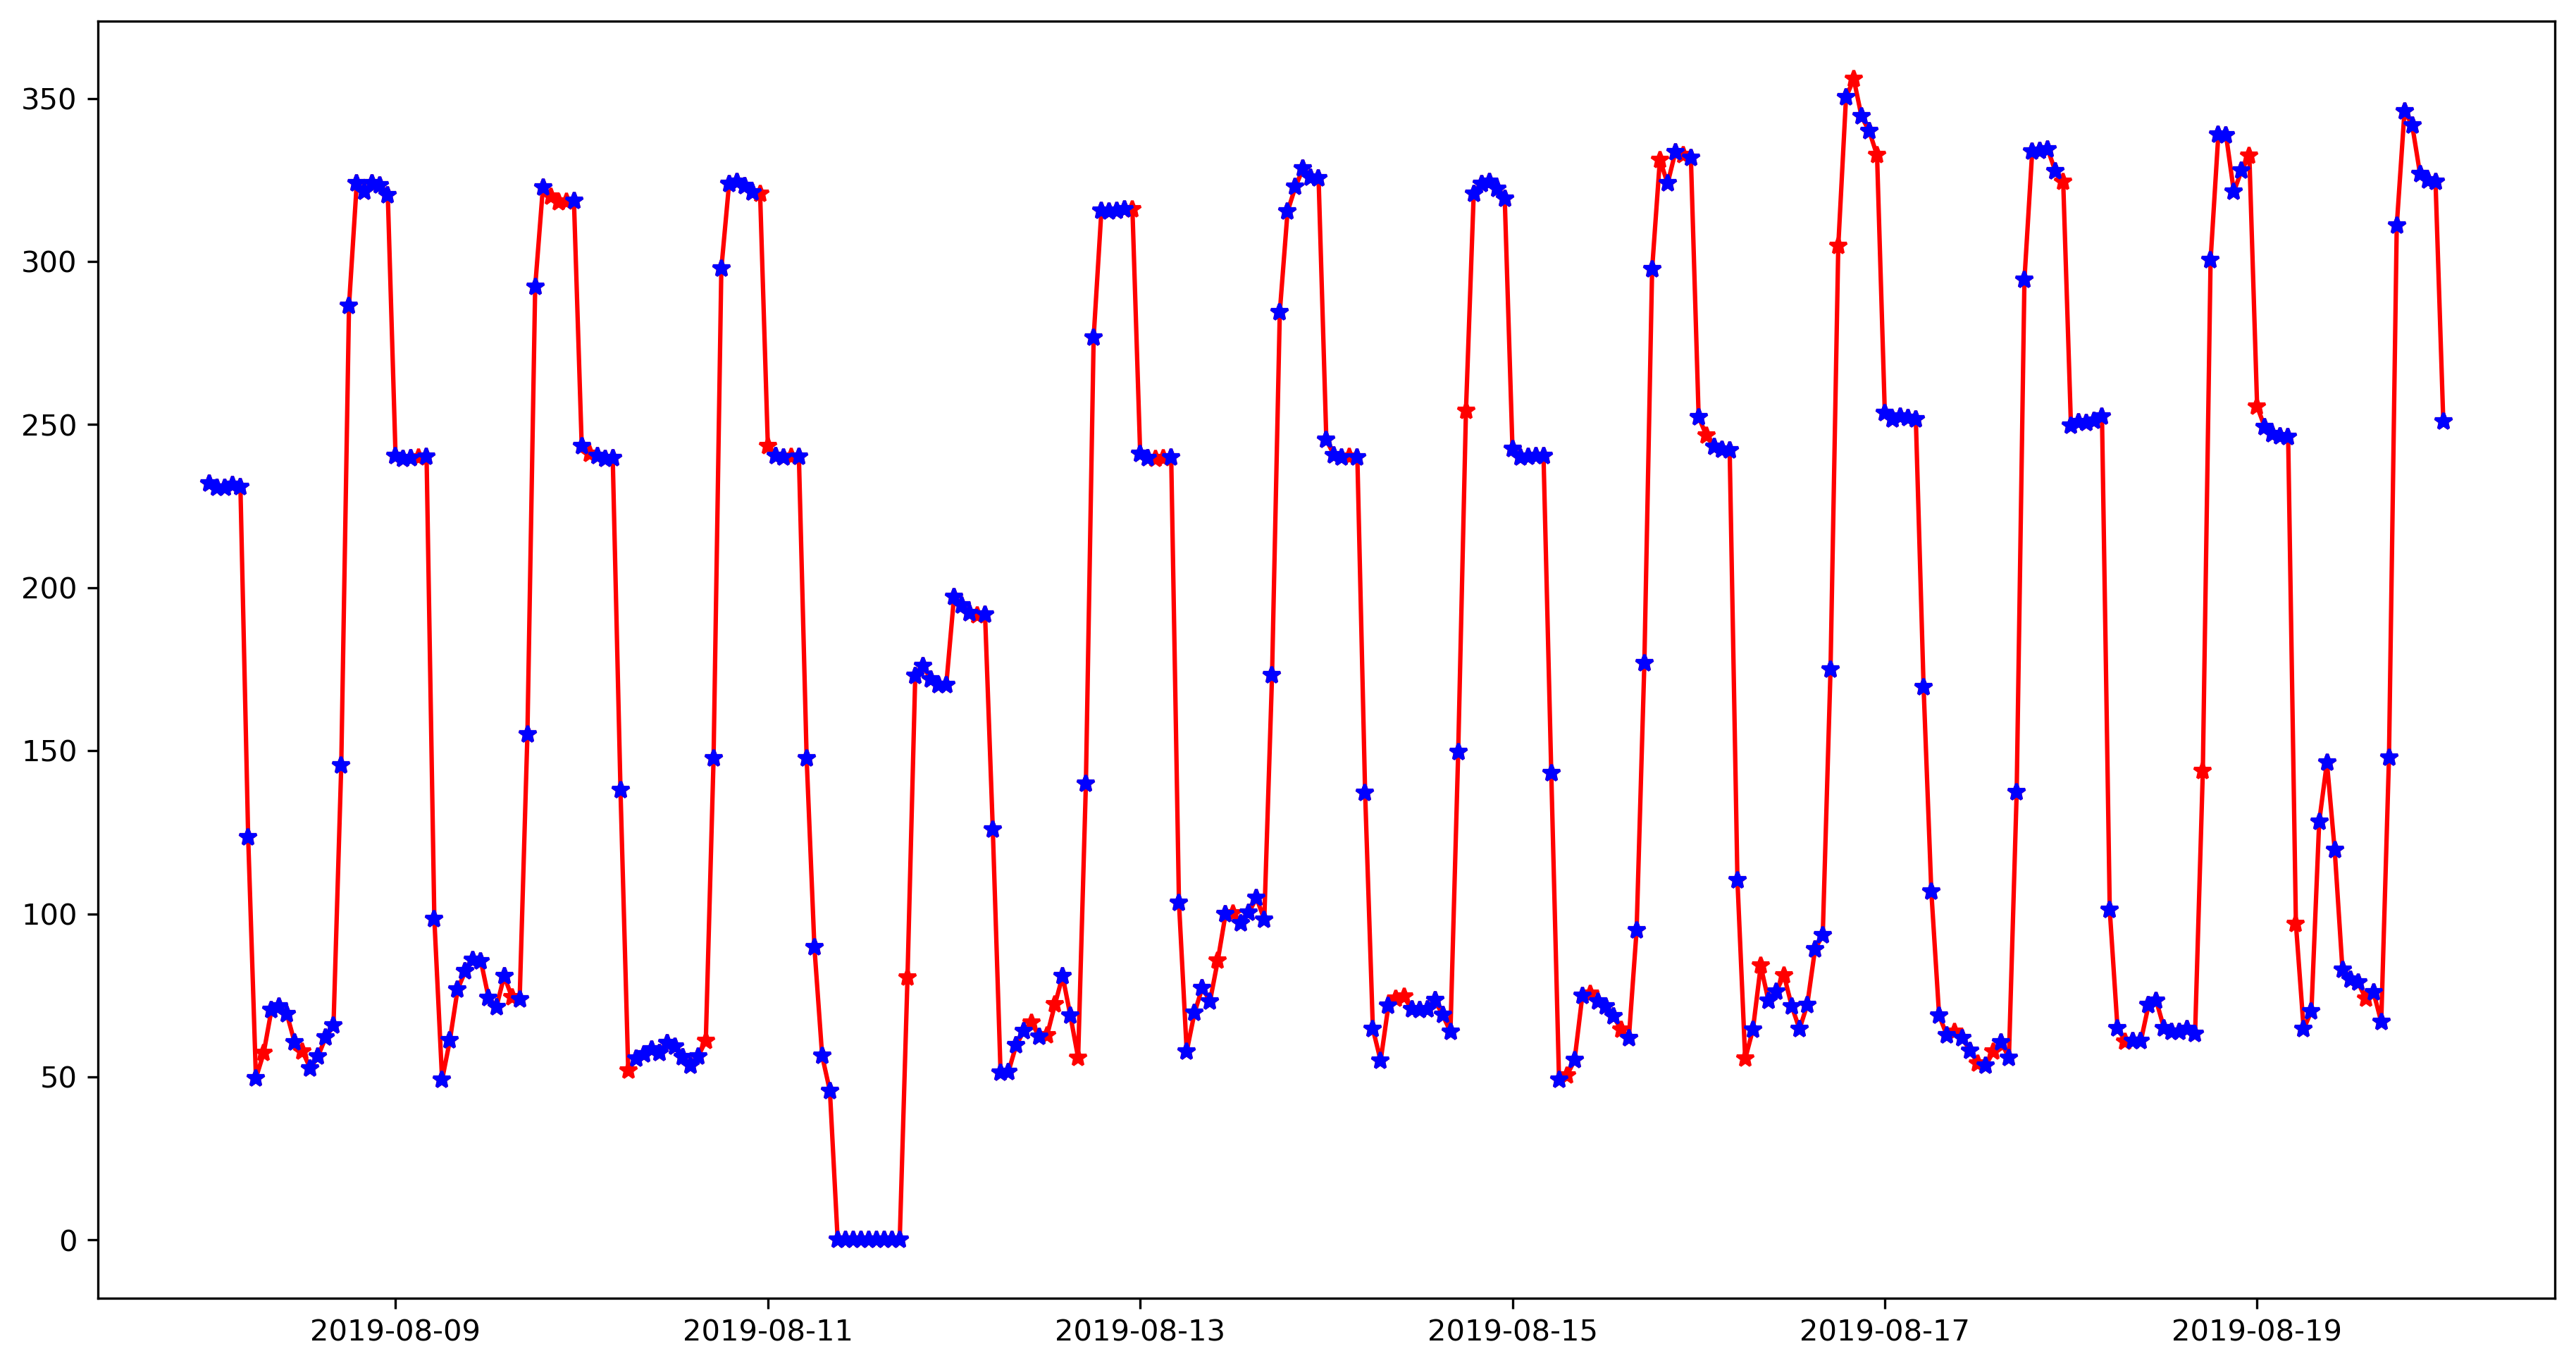

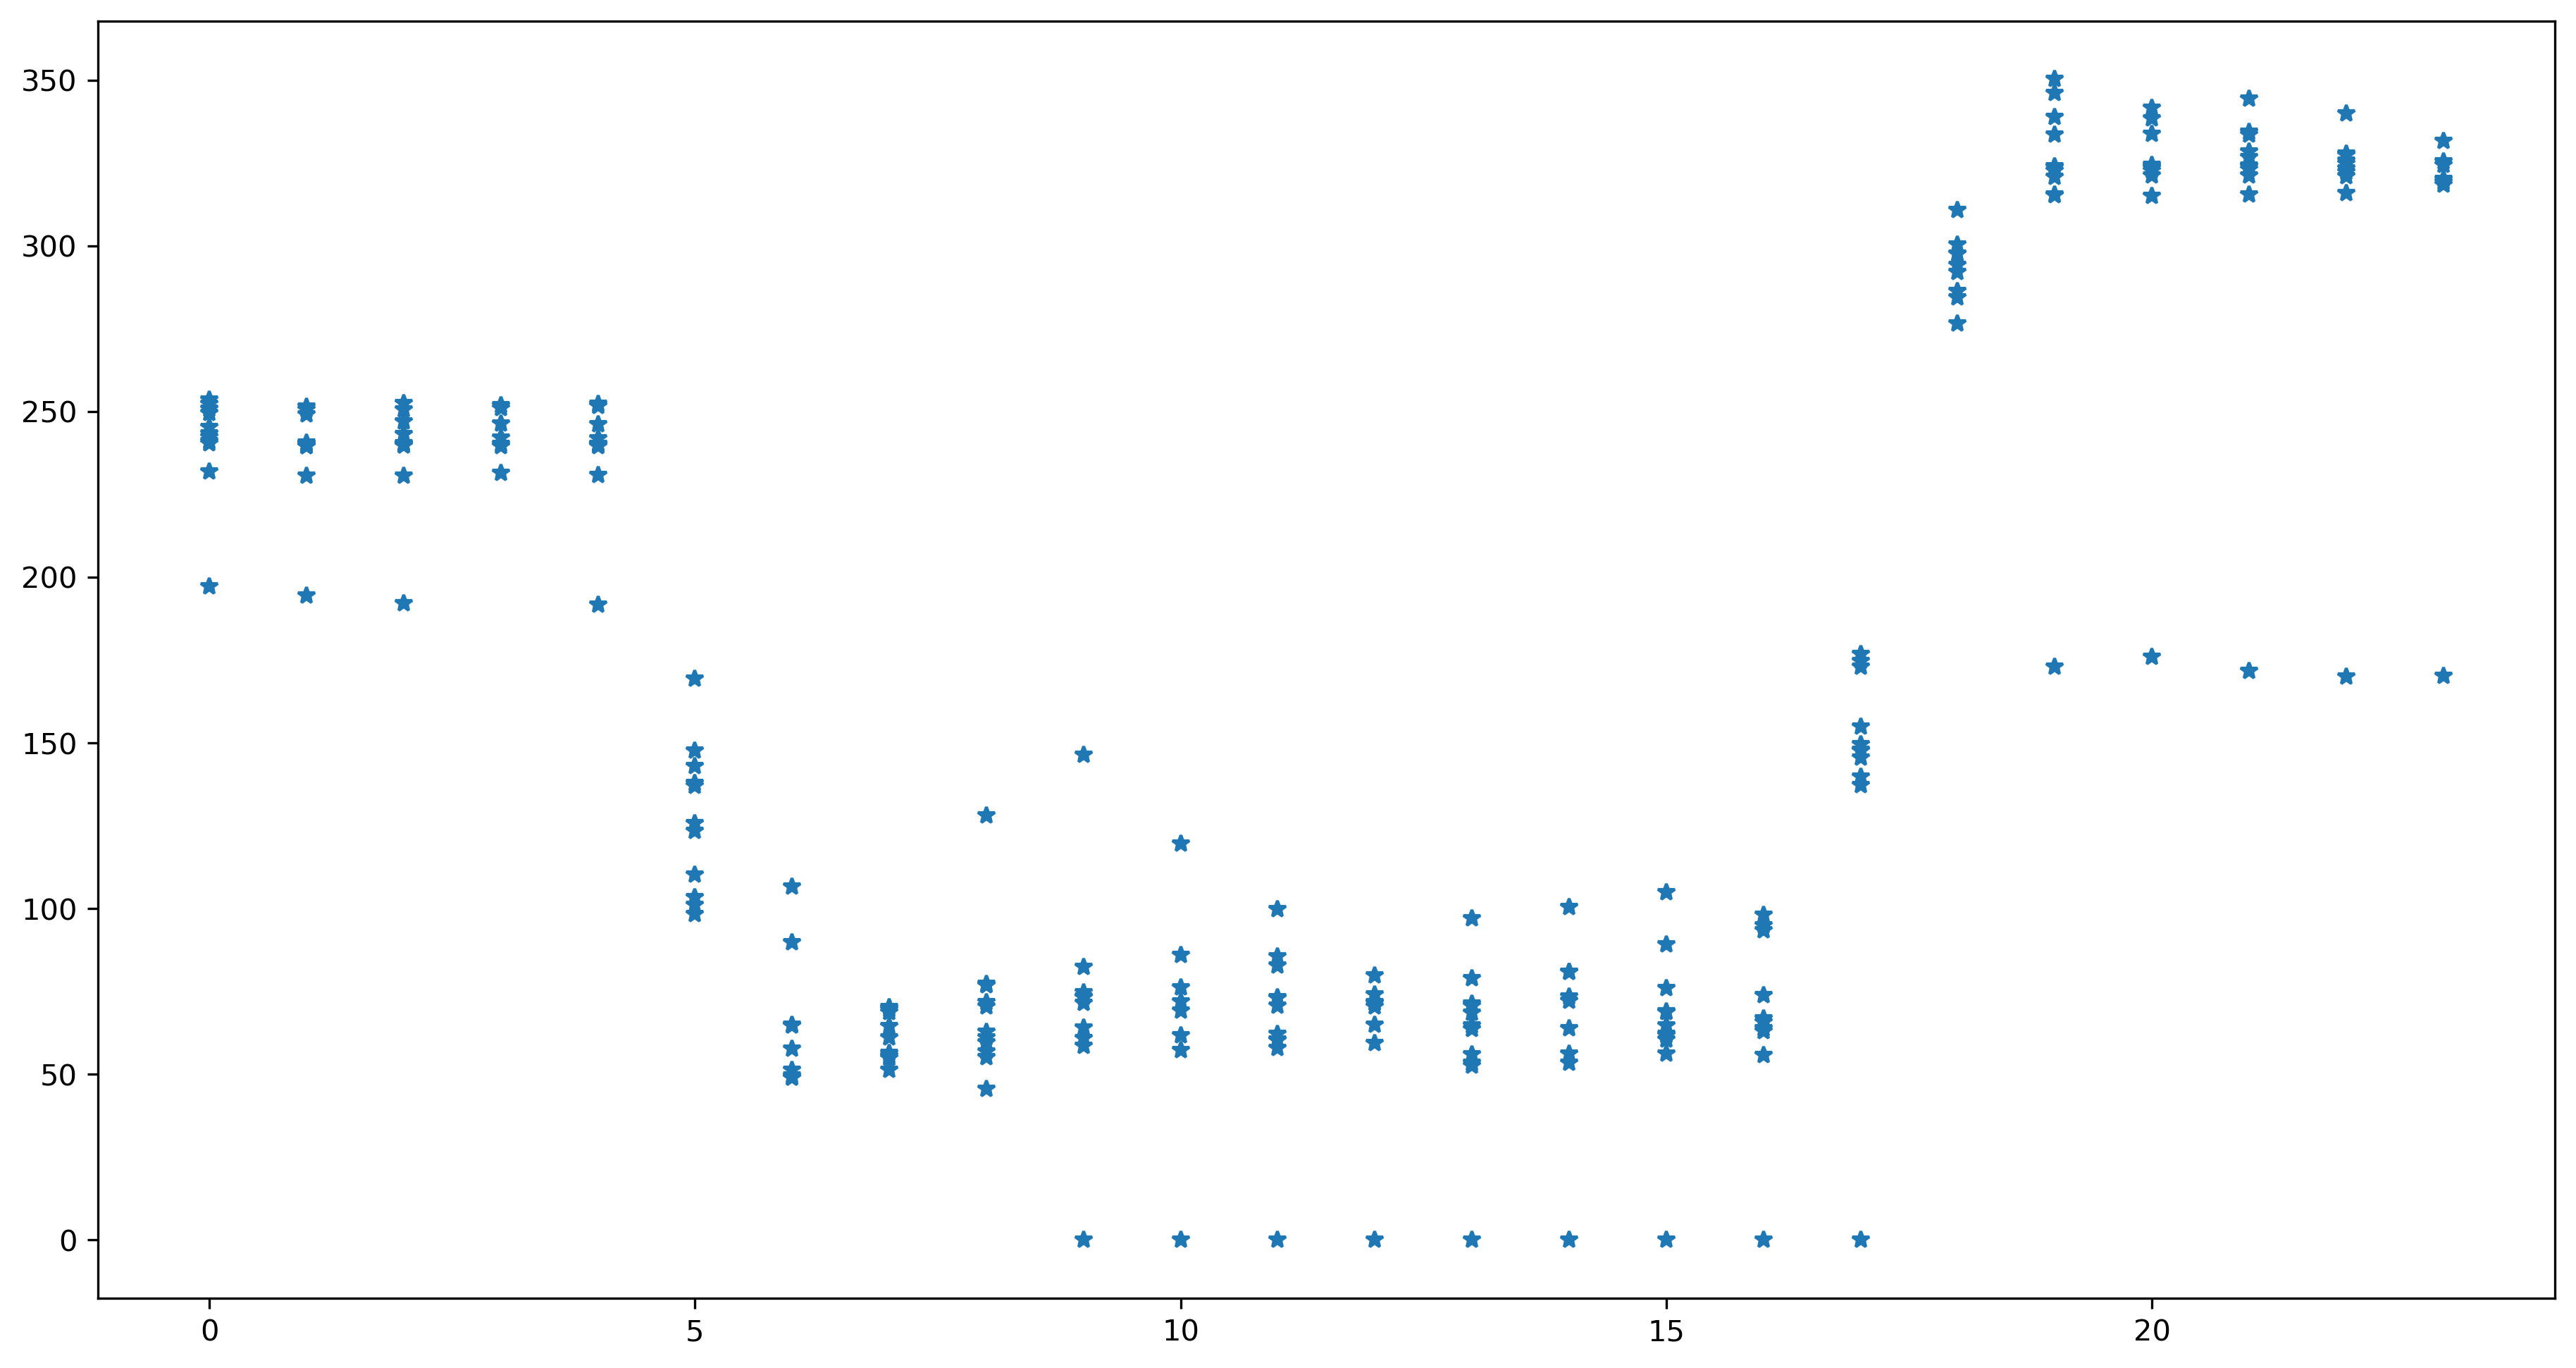

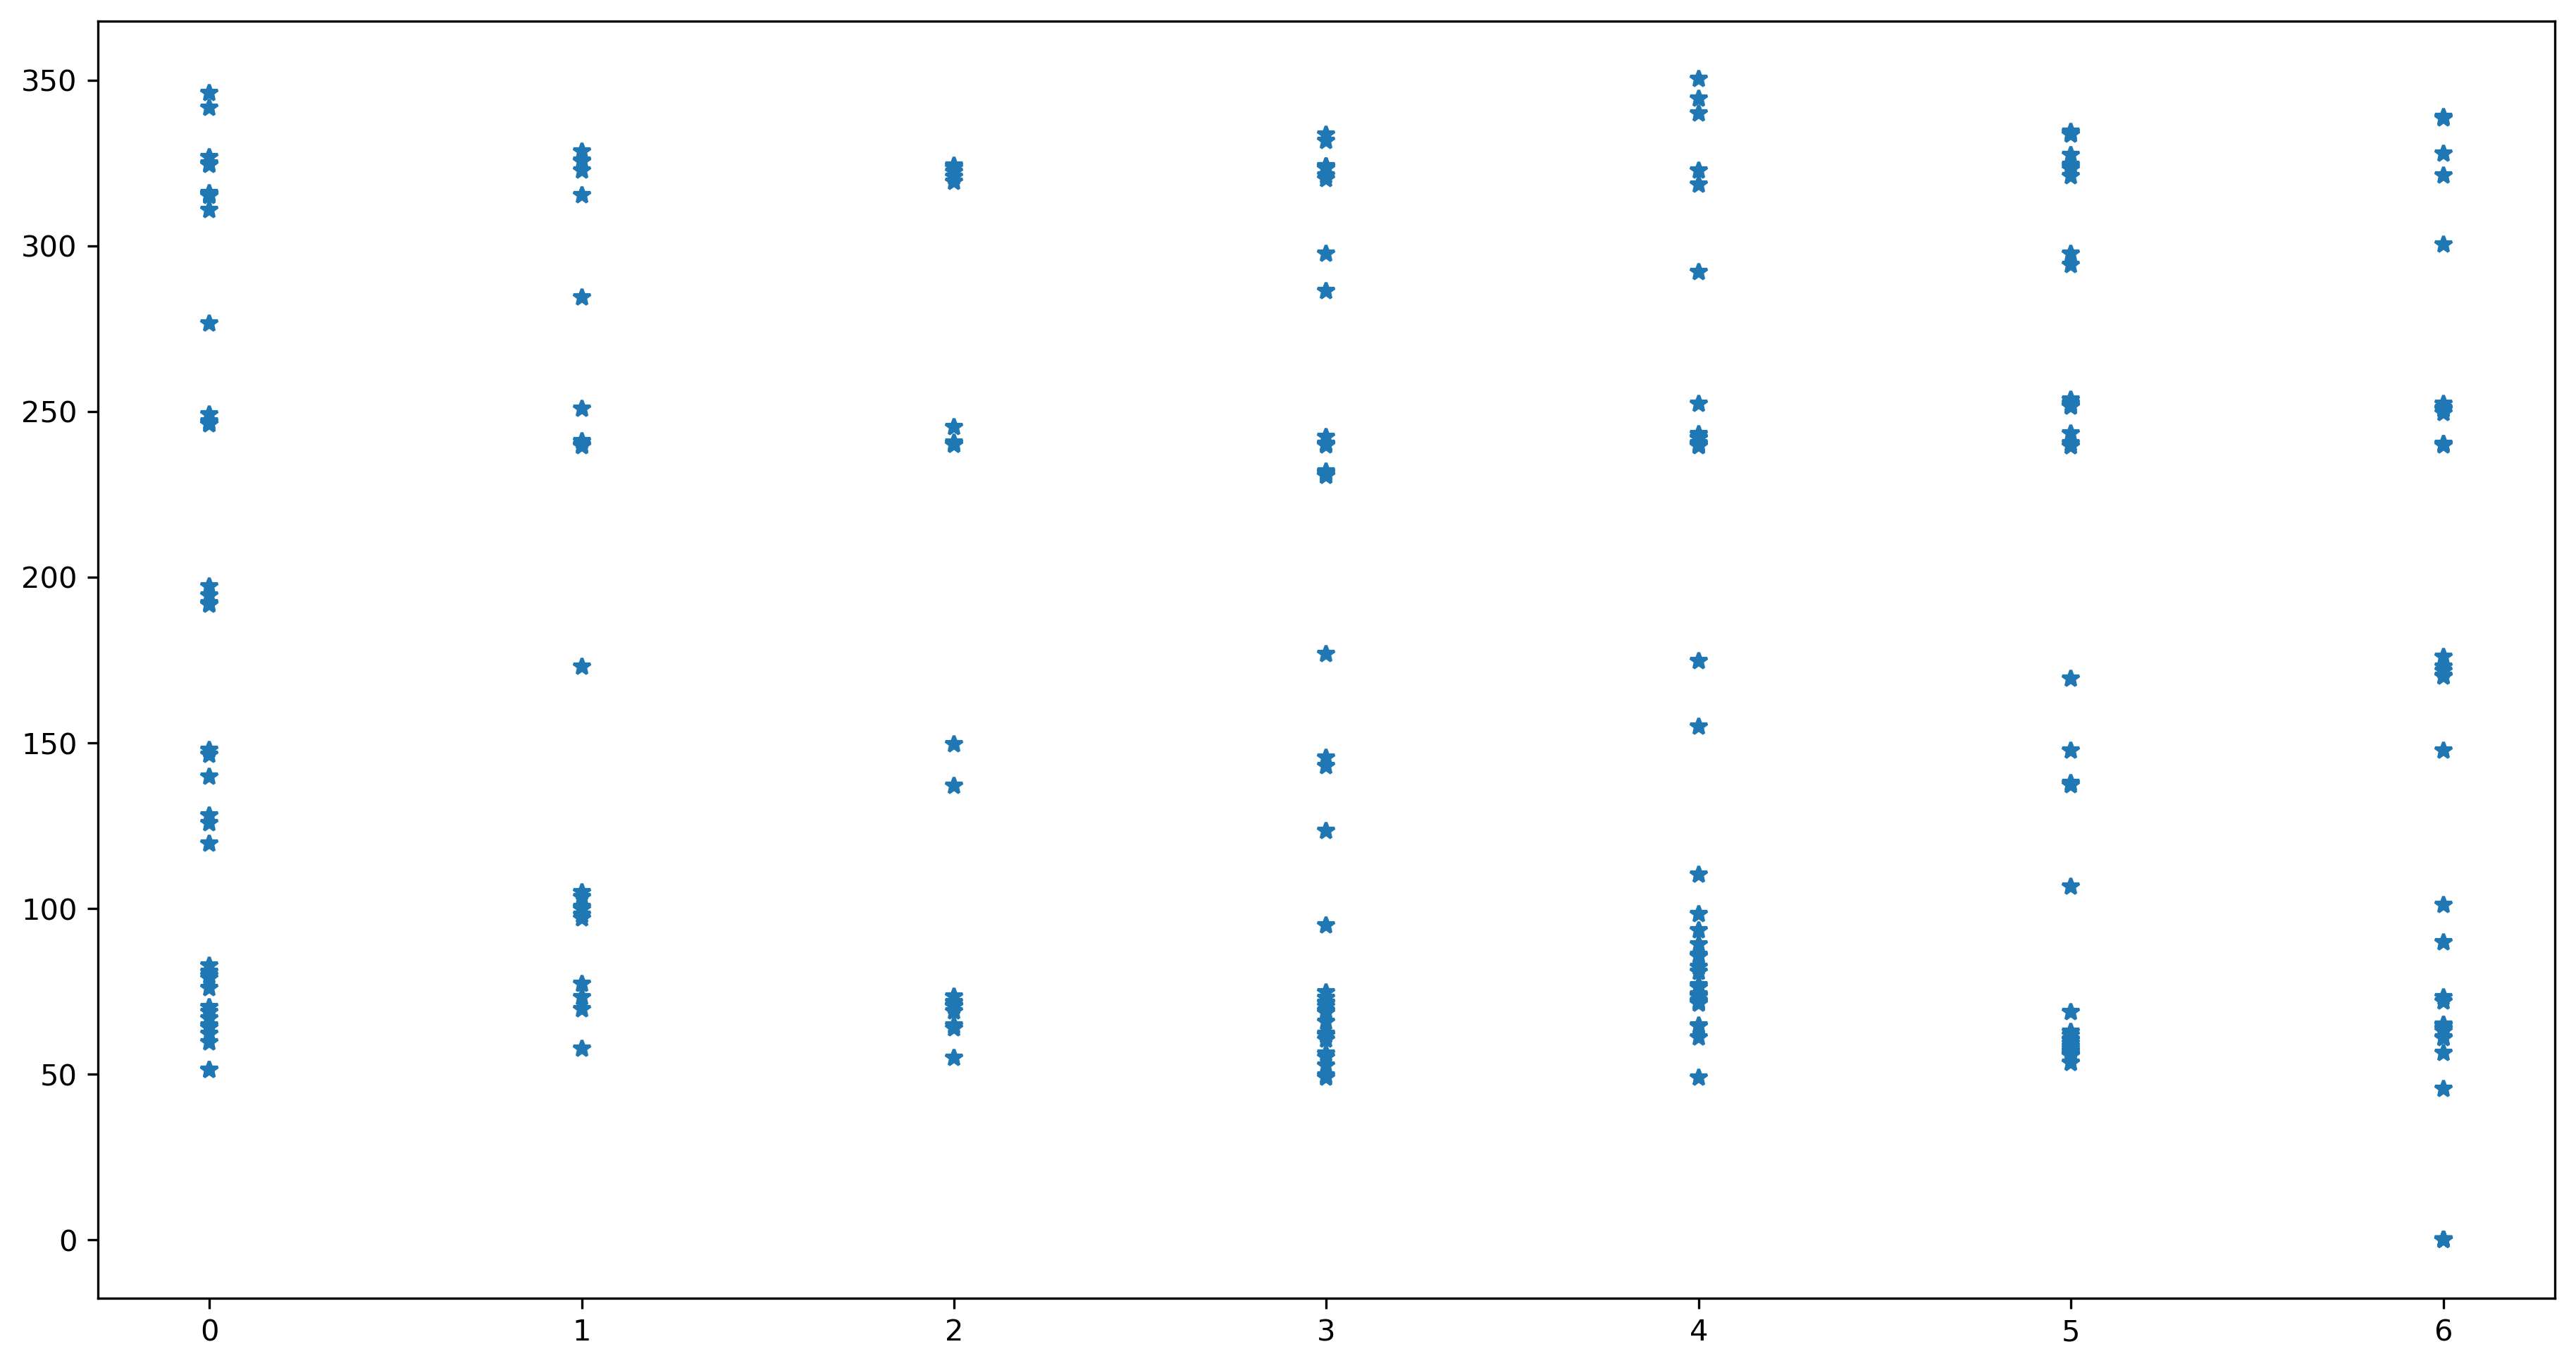

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

%matplotlib inline

fs=(15,8)


def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

df = pd.read_csv("../data/microgrid_processed_august.csv")
df.index = pd.to_datetime(df['timestamp'])
#Set
start_date =  "8/8/2019 0:00"
end_date = "8/20/2019 0:00"

#Parameter
dev = "AC_consumption_W"


df_hist = df[start_date:end_date][dev].to_frame()

fig, ax=plt.subplots(figsize=fs, dpi=300)    
ax.plot(df_hist,'r-*')

df_inpute = df_hist.copy()
drop_indices = np.random.choice(df_inpute.index, 50, replace=False)
# print(drop_indices)
df_inpute.loc[drop_indices,dev] = np.nan
df_inpute['hour'] = df_inpute.index.hour
df_inpute['day_wk'] = df_inpute.index.dayofweek

print("Covariance")
display(df_inpute.cov())
print("Correlation")
display(df_inpute.corr())
print("P_Values")
display(calculate_pvalues(df_inpute))

mean,cov = fiml(np.column_stack((df_inpute['hour'].values, df_inpute[dev].values)),True)
print(mean,cov)

mean,cov = fiml(np.column_stack((df_inpute['day_wk'].values, df_inpute[dev].values)),True)
print(mean,cov)

ax.plot(df_inpute[dev],'b*')
plt.show()


fig, ax=plt.subplots(figsize=fs, dpi=300)    
ax.plot(df_inpute["hour"],df_inpute[dev],'*')
plt.show()
fig, ax=plt.subplots(figsize=fs, dpi=300)    
ax.plot(df_inpute["day_wk"],df_inpute[dev],'*')
plt.show()

In [3]:
keys = [x for x in list(df.keys()) if x not in ['timestamp','Pot_PV_power_W','Charged_energy_W','State_of_charge']]
keys = [x for x in keys if 'AC_Day_Energy_session' not in x]

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dict_res = {}
dict_res['variable']=[]
dict_res['corr_H']=[]
dict_res['p_val_H']=[]
dict_res['corr_D']=[]
dict_res['p_val_D']=[]

print(keys)
for key in keys:
    df_local = df[start_date:end_date][key].to_frame()
    df_local['hour'] = df_local.index.hour
    df_local['day'] = df_local.index.day
    
    dict_res['variable'].append(key)
    dict_res['corr_H'].append(df_local.corr().loc[key,"hour"])
    dict_res['p_val_H'].append(calculate_pvalues(df_local).loc[key,"hour"])
    dict_res['corr_D'].append(df_local.corr().loc[key,"day"])
    dict_res['p_val_D'].append(calculate_pvalues(df_local).loc[key,"day"])

    
df_res = pd.DataFrame.from_dict(dict_res)
display(df_res)

['AC_consumption_W', 'Discharged_energy_W', 'PV_power_W', 'Nur 1A S1 vRELAY1_LVL', 'Nur 1A S2 vRELAY1_LVL', 'Nur 1B S1 vRELAY1_LVL', 'Nur 1C S1 vRELAY1_LVL', 'Nur 2A S1 vRELAY1_LVL', 'Nur 2A S2 vRELAY1_LVL', 'Nur 2B S1 vRELAY1_LVL', 'Nur 2C S1 vRELAY1_LVL', 'Playground S1 vRELAY1_LVL', 'Playground S2 vRELAY1_LVL', 'Nur 1A CPE1 LED1_P', 'Nur 1A CPE1 LED2_P', 'Nur 1A CPE1 LED3_P', 'Nur 1A CPE2 LED1_P', 'Nur 1A CPE2 LED2_P', 'Nur 1A CPE2 LED3_P', 'Nur 1B CPE3 LED1_P', 'Nur 1B CPE3 LED2_P', 'Nur 1B CPE3 LED3_P', 'Nur 1B CPE4 LED1_P', 'Nur 1B CPE4 LED2_P', 'Nur 1B CPE4 LED3_P', 'Nur 1C CPE5 LED1_P', 'Nur 1C CPE5 LED2_P', 'Nur 1C CPE5 LED3_P', 'Nur 1C CPE6 LED1_P', 'Nur 1C CPE6 LED2_P', 'Nur 1C CPE6 LED3_P', 'Nur 2A CPE7 LED1_P', 'Nur 2A CPE7 LED2_P', 'Nur 2A CPE7 LED3_P', 'Nur 2A CPE8 LED1_P', 'Nur 2A CPE8 LED2_P', 'Nur 2A CPE8 LED3_P', 'Nur 2B CPE10 LED1_P', 'Nur 2B CPE10 LED2_P', 'Nur 2B CPE10 LED3_P', 'Nur 2B CPE9 LED1_P', 'Nur 2B CPE9 LED2_P', 'Nur 2B CPE9 LED3_P', 'Nur 2C CPE11 LED1_P'

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,variable,corr_H,p_val_H,corr_D,p_val_D
0,AC_consumption_W,0.267729,0.0000,0.082890,0.1599
1,Discharged_energy_W,0.206175,0.0004,0.043766,0.4586
2,PV_power_W,-0.110297,0.0611,0.020785,0.7250
3,Nur 1A S1 vRELAY1_LVL,-0.101148,0.0861,-0.199548,0.0006
4,Nur 1A S2 vRELAY1_LVL,-0.034888,0.5547,-0.130968,0.0260
5,Nur 1B S1 vRELAY1_LVL,-0.028187,0.6332,-0.153346,0.0090
6,Nur 1C S1 vRELAY1_LVL,NaN,NaN,NaN,NaN
7,Nur 2A S1 vRELAY1_LVL,-0.057965,0.3261,-0.007366,0.9008
8,Nur 2A S2 vRELAY1_LVL,0.020286,0.7313,0.086450,0.1426
9,Nur 2B S1 vRELAY1_LVL,0.026591,0.6526,0.254333,0.0000
